## KIỂM TRA THƯỜNG KÌ 3
#### Ngô Hồng Thông
#### 22649011

# 1. Introduction

Trong bài tập này, ta sẽ tìm hiểu và triển khai một quy trình hệ thống đề xuất end-to-end dựa trên thuật toán phân tích ma trận. Chúng ta sẽ sử dụng tập dữ liệu MovieLens để huấn luyện mô hình và tiến hành các thử nghiệm. Nhiệm vụ của tập dữ liệu này là đề xuất những bộ phim mà người dùng có khả năng cao sẽ thích, dựa trên sở thích phim trước đây của họ. Đây cũng là một nhiệm vụ quan trọng, vì nó vẫn được sử dụng rộng rãi để đánh giá tiến độ trong cộng đồng nghiên cứu hệ thống đề xuất.

## 1.1 Installing libraries

Before we begin, we must make sure to install the libraries for the tutorial. To do this, we can use Python's package installer `pip`. Now go ahead and execute the following cell by selecting it and clicking `shift`+`Enter`.

In [56]:
import numpy as np
import pandas as pd

# Data vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
import utilities as utl

We have also prepared some boilerplate functions that we have grouped together in the `utilities` module. It is not necessary for you to look at these in order to complete the tutorial, but if you are curious, it is definitely a good idea to take a look at them!

## 1.2 Task setup and Data

The objective of a recommender system is to model users' historical behaviors such that we can predict what an individual user will most likely enjoy in the future. In short, we would like to create recommendations that are personalized to each user's interest.

The concept of an item might seem a bit fuzzy at first. But in fact, in the world of recommender systems, we always speak about users and items. Items can be anything a user interacts with, ranging from: products, movies, social media posts, news articles, search results, Instagram photos, restaurants, Pinterest pins and the list goes on. Not so surprisingly, majority of internet companies we interact with on a daily basis run some sort of recommender system in the background.

These recommender systems try to predict what will the most relevant item to show us given our user-item interactions. These interactions are often categorized as follows: implicit signals (e.g. likes, views, searches, purchases, installations, music listening behavior etc.) and explicit singals (e.g. ratings, reviews). Both types of signals can be used to help us define how to capture the users' interest, i.e. the user preference. And naturally, some signals suggest stronger proxies for user preferences (e.g. purchases, ratings) than others (e.g. views, clicks, time spent looking at an item).

<img src = "https://user-images.githubusercontent.com/13997178/90336890-0f8fba00-dfdf-11ea-9e32-d6b00988bd10.png" width = "350">

We can collect these user-item interactions to form a user preference vector, i.e. a vector that contains all historical interactions of the user with items that are relevant to our given task.

But how do we then use these user preference vectors to generate personalized recommendations?

Do we need to use all historical interactions? Doesn't user taste change over time? What if recommendations reinforce a user's previous choices?
Do we want to recommend complementary, sustitute or independent items from what the user has interacted with previously? 
Shall we try instead to show her items that she has not yet been exposed to? 
How do we balance how much exposure items get that are already very popular? What to do in cold-start scenarios when a new user or new item joins our platform?

These are just few of the many considerations that one would have to think about before designing a recommender system for a downstream use case. In fact, there is an outstanding community that actively conducts research on some of these questions (e.g. see [RecSys](https://recsys.acm.org/)). There is not a single answer to these considerations - it really just depends on your individual use case. However, the answer will affect not only which models you will use, but also what data you will feed to your model, and how you will set up your objective.

In the context of this tutorial, we will focus on recommending movies that users will like according to their past movie ratings. In order to carry out this task, we will use users' movie ratings, some relevant sociodemographic data as well as various features describing movies. Finally, we can refine the diagram as follows:

<img src = "https://user-images.githubusercontent.com/13997178/90336926-4b2a8400-dfdf-11ea-8379-0f38fc104e85.png" width = "750">

## 1.3 The MoviesLens dataset(s)

The data used here consist of more or less 100k movie evaluations by 943 users. Over 1,6k movies are available. In addition to the 100k evaluations, additional information related to users and movies is available.

We will use three different datasets to carry out our analyses:

<ul>
<li> Users : related to users' characteristics,
<li> Movies : related to movies' characteristics,
<li> Ratings : containing over 100k evaluations.
</ul>

We used the <a href="https://pandas.pydata.org/">Pandas</a> library in order to download and manipulate the datasets.

### 1.3.1 Users: Download and preprocessing

In [57]:
# Read dataset
users = pd.read_csv('ml-100k/u.user' , sep='|', header=None, engine='python', encoding='latin-1')

# Columns describing user characteristics
users.columns = ['Index', 'Age', 'Gender', 'Occupation', 'Zip code']

# Quick overview
users.head()

,Index,Age,Gender,Occupation,Zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [58]:
print('Number of users x features:', users.shape)

Number of users x features: (943, 5)


Before presenting some descriptive statistics related to the population, we transform the users' data in a <a href="https://en.wikipedia.org/wiki/List_(abstract_data_type)">list</a> in order to be able to handle them more easily. 

We first encode users' gender - originally stored as a string - with either 0 or 1. 
Then similarly, since occupations are also recorded as a string value, we would like to instead encode this into a binary array indicating the presence of each occupation.
Finally, we concatanate each user feature (i.e. age, gender and occupation) into a list per each user.

In [59]:
# Number of users
nb_users = len(users)

# Gender: Convert 'M' and 'F' to 0 and 1
gender = np.where(np.matrix(users['Gender']) == 'M', 0, 1)[0]

print('Shape of gender features:', gender.shape)

# Occupation
occupation_name = np.array(pd.read_csv('ml-100k/u.occupation', 
                                            sep='|', header=None, engine='python', encoding='latin-1').loc[:, 0])

# Boolean transformation of user's occupation
occupation_matrix = np.zeros((nb_users, len(occupation_name)))

for k in np.arange(nb_users):
    occupation_matrix[k, occupation_name.tolist().index(users['Occupation'][k])] = 1

print('Shape of user occupation matrix (num of users x num of occupations):', occupation_matrix.shape)

# Concatenation of the sociodemographic variables 
user_attributes = np.concatenate((np.matrix(users['Age']), np.matrix(gender), occupation_matrix.T)).T.tolist()

print('Shape of final user attribute matrix: (list of users with 23 features):', len(user_attributes), len(user_attributes[0]))

Shape of gender features: (943,)
Shape of user occupation matrix (num of users x num of occupations): (943, 21)
Shape of final user attribute matrix: (list of users with 23 features): 943 23


We then explore the descriptive statistics of the users. These include information related to age (continuous variable), gender (binary variable) and occupation of each user (21, all binary).

#### Descriptive statistics related to users'  *age*.

In [60]:
pd.DataFrame(users['Age'].describe()).T

,count,mean,std,min,25%,50%,75%,max
Age,943.0,34.051962,12.19274,7.0,25.0,31.0,43.0,73.0


#### Percentage of users per *gender*.

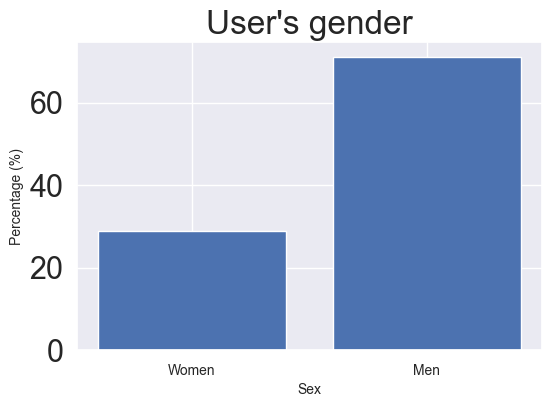

In [61]:
utl.barplot(['Women', 'Men'], np.array([np.mean(gender) , 1 - np.mean(gender)]) * 100, 
            'Sex', 'Percentage (%)', "User's gender", 0)

#### Percentage of users per *occupation*.

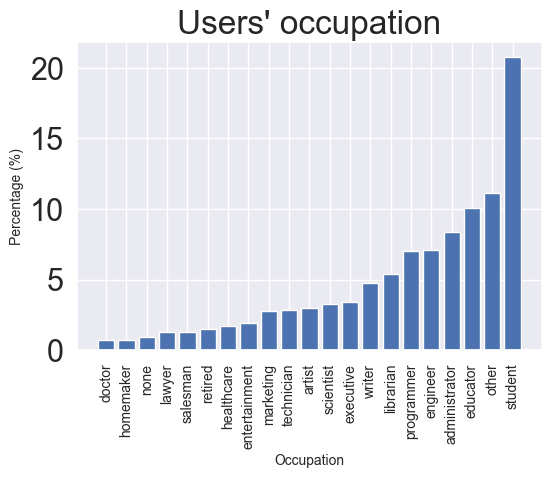

In [62]:
attributes, scores = utl.rearrange(occupation_name, np.mean(occupation_matrix, axis=0) * 100)
utl.barplot(attributes, scores, 'Occupation', 'Percentage (%)', "Users' occupation", 90)

It is now a good time to pause and reflect what these various user characteristics tell us. We see that majority of our users are men, and 20+ % of them are students, with a median age of 31. What does that mean for our model?
Ideally, if we were to use this dataset to train a model on it, it would reflect the overall popular of movie watchers we will serve recommendations to. 

## Question 1
> Bạn nghĩ sao nếu ngày mai chúng ta triển khai một chiến dịch mới, cho phép xem tất cả phim miễn phí? Bạn nghĩ các đề xuất của chúng ta được đào tạo dựa trên tập dữ liệu này sẽ thay đổi như thế nào? Nếu chúng ta triển khai một chiến dịch khác, tăng giá thuê phim lên gấp 3 lần thì sao? Lượng người xem phim cơ bản sẽ thay đổi như thế nào?

In [63]:
#TODO 1.
"""
Phân tích ảnh hưởng của các chiến dịch pricing đến hệ thống khuyến nghị:

1. CHIẾN DỊCH XEM PHIM MIỄN PHÍ:
   
   Thay đổi về hành vi người dùng:
   - Số lượng phim được xem sẽ TĂNG đáng kể (do không còn rào cản về giá)
   - Người dùng sẽ xem nhiều phim hơn, kể cả những phim họ "tò mò" nhưng không sẵn sàng trả tiền
   - Ma trận rating sẽ trở nên ÍT SPARSE hơn (nhiều ô được điền hơn)
   
   Ảnh hưởng đến recommendations:
   - Model sẽ có NHIỀU DỮ LIỆU HƠN để học → cải thiện chất lượng đề xuất
   - Nhưng ratings có thể bị BIASED: người dùng có thể cho rating thấp cho phim họ xem "thử" 
     mà không thực sự quan tâm
   - Phim ít phổ biến sẽ được xem nhiều hơn → giảm popularity bias
   - Cold-start problem cho phim mới sẽ được cải thiện
   
   Thay đổi về user demographics:
   - Thu hút thêm người dùng mới (học sinh, sinh viên, người có thu nhập thấp)
   - Phân bố user sẽ KHÔNG CÒN đại diện cho population hiện tại
   - Model cần được RETRAIN với dữ liệu mới

2. CHIẾN DỊCH TĂNG GIÁ GẤP 3 LẦN:
   
   Thay đổi về hành vi người dùng:
   - Số lượng phim được xem sẽ GIẢM mạnh
   - Người dùng chỉ xem những phim họ RẤT CHẮC CHẮN sẽ thích
   - Ma trận rating sẽ trở nên SPARSE HƠN (ít ô được điền)
   
   Ảnh hưởng đến recommendations:
   - Model có ÍT DỮ LIỆU HƠN để học → chất lượng đề xuất giảm
   - Ratings sẽ bị BIASED cao: chỉ phim chất lượng cao/blockbuster được xem
   - Tăng popularity bias (phim nổi tiếng được ưu tiên hơn)
   - Cold-start problem trở nên TỒI TỆ HƠN
   - Phim độc lập, nghệ thuật sẽ bị bỏ qua
   
   Thay đổi về user demographics:
   - Mất đi user có thu nhập thấp (sinh viên, người trẻ)
   - Chỉ còn user có khả năng chi trả cao
   - Distribution shift: model được train trên dữ liệu cũ sẽ KHÔNG PHẢN ÁNH 
     đúng user base mới

3. KẾT LUẬN:
   - Hệ thống recommendation được train trên dataset hiện tại sẽ BỊ LỖI THỜI
   - Cần MONITOR performance metrics và RETRAIN model thường xuyên
   - Cân nhắc sử dụng techniques như: domain adaptation, transfer learning
   - Có thể cần thiết kế lại objective function để phù hợp với business goals mới
"""

'\nPhân tích ảnh hưởng của các chiến dịch pricing đến hệ thống khuyến nghị:\n\n1. CHIẾN DỊCH XEM PHIM MIỄN PHÍ:\n   \n   Thay đổi về hành vi người dùng:\n   - Số lượng phim được xem sẽ TĂNG đáng kể (do không còn rào cản về giá)\n   - Người dùng sẽ xem nhiều phim hơn, kể cả những phim họ "tò mò" nhưng không sẵn sàng trả tiền\n   - Ma trận rating sẽ trở nên ÍT SPARSE hơn (nhiều ô được điền hơn)\n   \n   Ảnh hưởng đến recommendations:\n   - Model sẽ có NHIỀU DỮ LIỆU HƠN để học → cải thiện chất lượng đề xuất\n   - Nhưng ratings có thể bị BIASED: người dùng có thể cho rating thấp cho phim họ xem "thử" \n     mà không thực sự quan tâm\n   - Phim ít phổ biến sẽ được xem nhiều hơn → giảm popularity bias\n   - Cold-start problem cho phim mới sẽ được cải thiện\n   \n   Thay đổi về user demographics:\n   - Thu hút thêm người dùng mới (học sinh, sinh viên, người có thu nhập thấp)\n   - Phân bố user sẽ KHÔNG CÒN đại diện cho population hiện tại\n   - Model cần được RETRAIN với dữ liệu mới\n\n2. CHI

### 1.3.2 Movies: Download and preprocesssing

In the same way, we will now process and explore the data associated with movies. For each movie, we have the *title*, the *release date* in North America, as well as the corresponding *genres*.

In [64]:
# Read dataset
movies = pd.read_csv('ml-100k/u.item', sep='|', header=None, engine='python', encoding='latin-1')

# Number of movies
nb_movies = len(movies)
print('The number of movies is: ', nb_movies)

# Genres
movies_genre = np.matrix(movies.loc[:, 5:])
movies_genre_name = np.array(pd.read_csv('ml-100k/u.genre', sep='|', header=None, engine='python', encoding='latin-1').loc[:, 0])

# Quick overview
movies.columns = ['Index', 'Title', 'Release', 'The Not a Number column', 'Imdb'] + movies_genre_name.tolist()
movies.head()

The number of movies is:  1682


,Index,Title,Release,The Not a Number column,Imdb,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Percentage of movies per *genre*

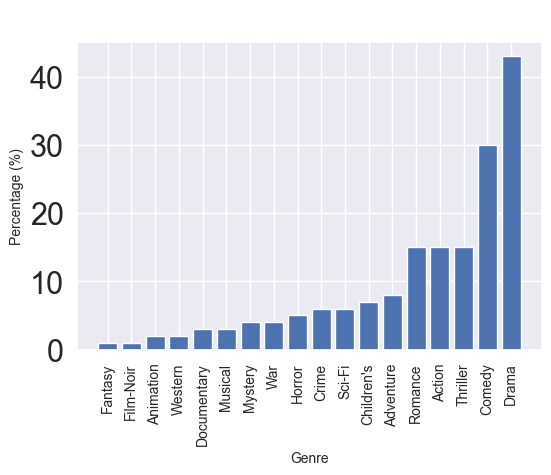

In [65]:
attributes, scores = utl.rearrange(movies_genre_name, 
                                   np.array(np.round(np.mean(movies_genre, axis=0) * 1, 2))[0])
utl.barplot(attributes, np.array(scores) * 100, xlabel='Genre', ylabel='Percentage (%)', 
            title=" ", rotation = 90)

### 1.3.3 Ratings: Download and preprocessing

The dataset based on users ratings consists of approximately 100k lines (one evaluation per line) where the following are presented: the *user identification number*, the *identification number of the movie*, its associated *rating* and *a time marker*. The training and test sets were provided as is, that is, we do not need to build them ourselves, and have 80k and 20k evaluations respectively.

For practical reasons, we convert the database as a list using our `convert` util function.

In [66]:
training_set = np.array(pd.read_csv('ml-100k/u1.base', delimiter='\t'), dtype='int')
testing_set = np.array(pd.read_csv('ml-100k/u1.test', delimiter='\t'), dtype='int')

print('Example sample (user idx, movie idx, rating, timestamp: ', training_set[0])
print('Shape of original training and test set with shape:     ', training_set.shape, testing_set.shape)


Example sample (user idx, movie idx, rating, timestamp:  [        1         2         3 876893171]
Shape of original training and test set with shape:      (79999, 4) (19999, 4)


In [67]:
train_set = utl.convert(training_set, nb_users, nb_movies)
test_set = utl.convert(testing_set, nb_users, nb_movies)

print('Shape of final training set: (list of users x list of all movies):', len(train_set), len(train_set[0]))
print('Shape of final test set:     (list of users x list of all movies):', len(test_set), len(test_set[0]))

Shape of final training set: (list of users x list of all movies): 943 1682
Shape of final test set:     (list of users x list of all movies): 943 1682


In [68]:
np.array(train_set).shape

(943, 1682)

As we did before, we can get descriptive statistics associated with the evaluations. At first, it might be interesting to study the average trends of users.

In [69]:
train_matrix = np.array(train_set)
assert train_matrix.shape == (943, 1682)

binarized_train_matrix = np.where(train_matrix > 0 , 1, 0)

num_movies_watched = np.sum(binarized_train_matrix, axis=1) ## sum across movies for each user
pd.DataFrame(num_movies_watched).describe().T

,count,mean,std,min,25%,50%,75%,max
0,943.0,84.834571,83.805787,4.0,27.0,50.0,115.0,685.0


I.e. The median user in our training set has watched 50 movies, with smallest number of movies watched being 4, and the most movies watched being 685.

#### Histogram of the number of movies watched per user.

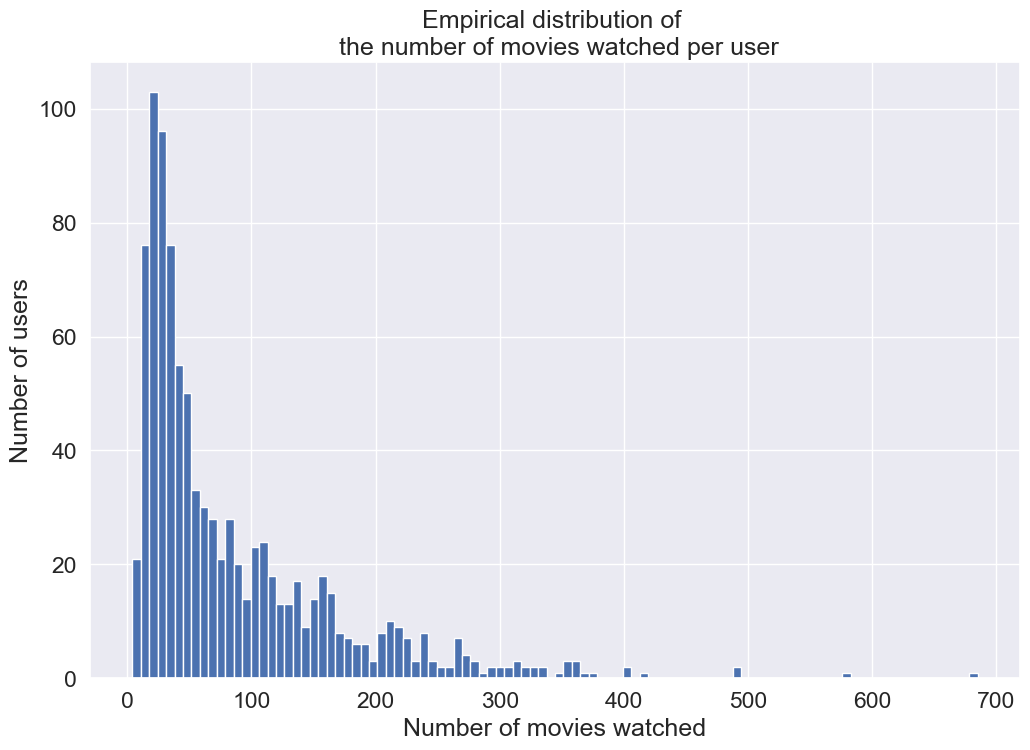

In [70]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)

plt.title('Empirical distribution of \n the number of movies watched per user')
plt.xlabel('Number of movies watched')
plt.ylabel('Number of users')
plt.hist(num_movies_watched, 100);

#### Percentage of users having seen a movie

In [71]:
movie_popularity = np.mean(binarized_train_matrix, axis=0)  ## axis 0 refers to averaging across users
pd.DataFrame(movie_popularity).describe().T

,count,mean,std,min,25%,50%,75%,max
0,1682.0,0.050437,0.068664,0.0,0.005302,0.022269,0.066808,0.513256


That is, 50% of movies were seen by less than 2% of users, whereas there are movies that were seen by either no user or by 51% of all users.
 
We can also plot this as a histogram and see how many movies were seen by what proportion of the population.


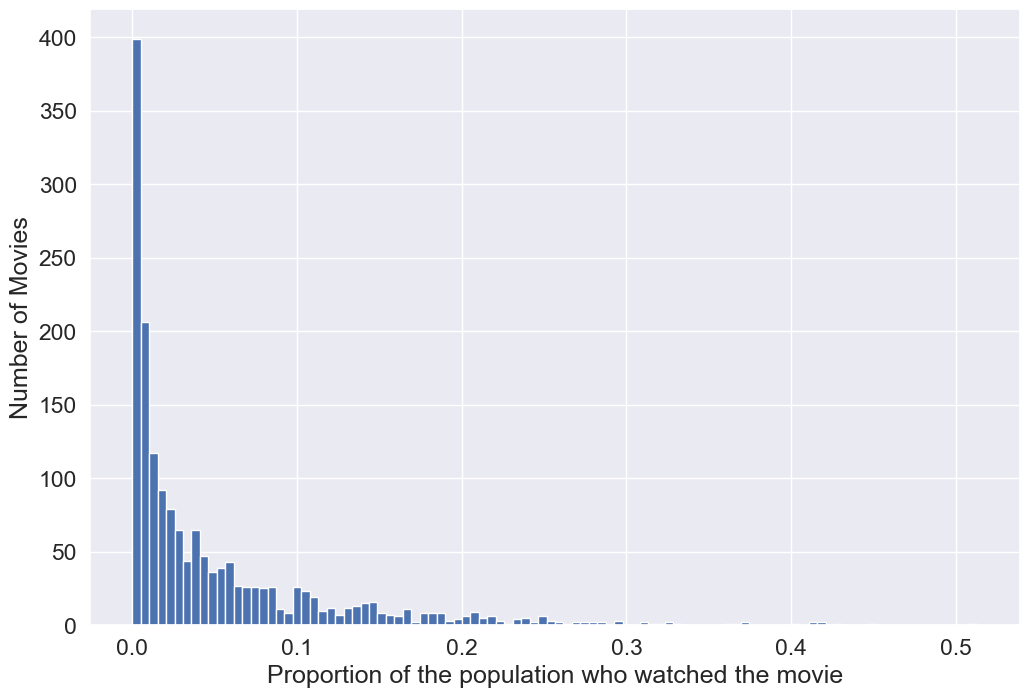

In [72]:
plt.xlabel('Proportion of the population who watched the movie')
plt.ylabel('Number of Movies')
plt.hist(movie_popularity, 100);

## Question 2

> Biểu đồ ở trên cho chúng ta biết điều gì về training matrix user-item?

In [73]:
#TODO 2.
"""
Biểu đồ histogram về tỷ lệ người dùng đã xem mỗi bộ phim cho chúng ta biết:

1. MA TRẬN RẤT THƯA (HIGHLY SPARSE):
   - Phần lớn các phim chỉ được xem bởi < 2% users (median = 2%)
   - Nghĩa là hầu hết các ô trong ma trận user-item đều là 0 (chưa có rating)
   - Với 943 users và 1682 movies → có 1,586,126 ô potential
   - Nhưng chỉ có ~100k ratings → sparsity = 1 - (100k/1.58M) ≈ 93.7% sparse

2. PHÂN BỐ LONG-TAIL (SKEWED DISTRIBUTION):
   - Biểu đồ có dạng exponential decay (giảm mạnh từ trái sang phải)
   - Rất nhiều phim ít người xem (unpopular movies)
   - Rất ít phim được nhiều người xem (max 51% users xem 1 phim)
   - → Popularity bias: một số phim blockbuster rất phổ biến, còn lại bị bỏ qua

3. COLD-START PROBLEM:
   - Có những phim không được ai xem (0% population)
   - Rất khó để recommend những phim này vì không có data
   - Model sẽ thiên về recommend những phim đã popular

4. ẢNH HƯỞNG ĐẾN MATRIX FACTORIZATION:
   - Sparsity cao → khó khăn trong việc học latent factors
   - Cần regularization mạnh để tránh overfitting
   - Model có thể bias về phim popular, bỏ qua niche movies
   - Cần nhiều epochs và data augmentation techniques

5. DATA QUALITY:
   - Chỉ một số ít users "active" (xem nhiều phim)
   - Majority của interactions tập trung vào một số phim nhất định
   - Không đủ data để capture long-tail preferences

KẾT LUẬN:
Training matrix rất SPARSE và có POPULARITY BIAS cao, đòi hỏi kỹ thuật đặc biệt 
để xử lý cold-start problem và cải thiện recommendations cho unpopular items.
"""

'\nBiểu đồ histogram về tỷ lệ người dùng đã xem mỗi bộ phim cho chúng ta biết:\n\n1. MA TRẬN RẤT THƯA (HIGHLY SPARSE):\n   - Phần lớn các phim chỉ được xem bởi < 2% users (median = 2%)\n   - Nghĩa là hầu hết các ô trong ma trận user-item đều là 0 (chưa có rating)\n   - Với 943 users và 1682 movies → có 1,586,126 ô potential\n   - Nhưng chỉ có ~100k ratings → sparsity = 1 - (100k/1.58M) ≈ 93.7% sparse\n\n2. PHÂN BỐ LONG-TAIL (SKEWED DISTRIBUTION):\n   - Biểu đồ có dạng exponential decay (giảm mạnh từ trái sang phải)\n   - Rất nhiều phim ít người xem (unpopular movies)\n   - Rất ít phim được nhiều người xem (max 51% users xem 1 phim)\n   - → Popularity bias: một số phim blockbuster rất phổ biến, còn lại bị bỏ qua\n\n3. COLD-START PROBLEM:\n   - Có những phim không được ai xem (0% population)\n   - Rất khó để recommend những phim này vì không có data\n   - Model sẽ thiên về recommend những phim đã popular\n\n4. ẢNH HƯỞNG ĐẾN MATRIX FACTORIZATION:\n   - Sparsity cao → khó khăn trong việc h

#### Individual preferences according to the type of movie

We could also look at the behavior of a particular individual. Among other things, we could study if there is a bias associated with her evaluation scheme or what are her cinematographic preferences according to the score awarded.

In [74]:
def stats_user(data, movies_genre, user_id):
    
    ratings = data[user_id]
    stats = np.zeros(6)
    eva = np.zeros((6, movies_genre.shape[1]))

    for k in np.arange(len(ratings)):
        index = int(ratings[k])
        stats[index] += 1
        eva[index, :] = eva[index, :] + movies_genre[k]

    return stats, eva

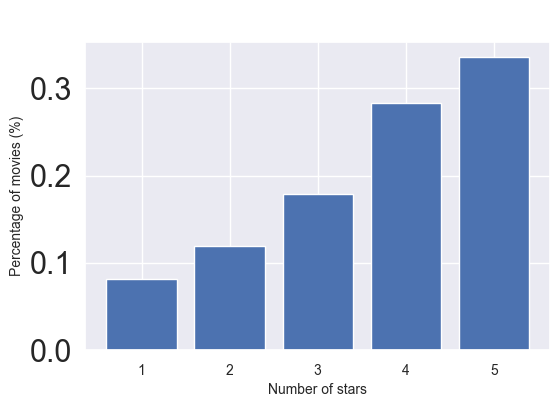

In [75]:
user_id = 0
num_of_star_ratings, genre_based_ratings = stats_user(train_set, movies_genre, user_id)
utl.barplot(np.arange(5) + 1, num_of_star_ratings[1:6] / sum(num_of_star_ratings[1:6]), xlabel='Number of stars', ylabel='Percentage of movies (%)', 
            title=" ", rotation = 0)

# Question 3

Làm thế nào chúng ta có thể kiểm tra sự tồn tại của bias ​​liên quan đến model đánh giá cá nhân?

In [76]:
#TODO 3.
"""
Các phương pháp kiểm tra sự tồn tại của BIAS trong model đánh giá cá nhân:

1. PHÂN TÍCH PHÂN BỐ RATING CỦA USER:
   
   a) Central Tendency Bias (Xu hướng đánh giá trung bình):
   - Tính mean và median của ratings cho mỗi user
   - Vẽ histogram phân bố ratings của từng user
   - Kiểm tra xem user có xu hướng cho điểm trung bình (3 sao) hay không
   
   Code example:
   user_ratings = [r for r in train_set[user_id] if r > 0]
   mean_rating = np.mean(user_ratings)
   std_rating = np.std(user_ratings)
   
   # Nếu std_rating thấp và mean gần 3 → có central tendency bias

   b) Positivity/Negativity Bias:
   - Đếm số lượng ratings cao (4-5 sao) vs thấp (1-2 sao)
   - Tính tỷ lệ: positive_ratio = count(rating >= 4) / total_ratings
   - Nếu positive_ratio > 0.7 → positivity bias
   - Nếu positive_ratio < 0.3 → negativity bias

2. SO SÁNH VỚI BASELINE:
   
   - Tính global average rating: global_avg = mean(all_ratings)
   - Tính user average rating: user_avg = mean(user_ratings)
   - User bias = user_avg - global_avg
   
   # Nếu user_bias > 0.5 → user có xu hướng đánh giá cao hơn trung bình
   # Nếu user_bias < -0.5 → user có xu hướng đánh giá thấp hơn trung bình

3. PHÂN TÍCH VARIANCE:
   
   - Tính variance của ratings: var_rating = np.var(user_ratings)
   - Nếu variance thấp (< 0.5) → user ít phân biệt giữa các phim
   - Nếu variance cao (> 2.0) → user có ý kiến rõ ràng, phân biệt rõ

4. KIỂM TRA RANGE RESTRICTION:
   
   - Kiểm tra xem user có sử dụng full scale (1-5) không
   - rating_range = max(user_ratings) - min(user_ratings)
   - Nếu rating_range < 2 → user không sử dụng đầy đủ thang điểm

5. TEMPORAL BIAS (Bias theo thời gian):
   
   - Phân tích ratings theo thứ tự thời gian
   - Kiểm tra xem có xu hướng tăng/giảm theo thời gian không
   - Có thể dùng linear regression để detect trend

6. GENRE BIAS:
   
   - Sử dụng hàm stats_user đã có để phân tích
   - Kiểm tra xem user có xu hướng rate cao một số genre nhất định
   - Tính average rating cho mỗi genre
   
   Code example:
   _, genre_ratings = stats_user(train_set, movies_genre, user_id)
   avg_rating_per_genre = np.mean(genre_ratings[1:6], axis=0)

7. VISUALIZATION METHODS:
   
   a) Box plot: So sánh distribution của ratings giữa các users
   b) Histogram: Xem phân bố ratings của từng user
   c) Heatmap: Visualize user-item matrix để thấy patterns
   
   plt.hist(user_ratings, bins=5, range=(1,6))
   plt.title(f'Rating Distribution for User {user_id}')

8. STATISTICAL TESTS:
   
   - Chi-square test: Kiểm tra xem distribution có khác với expected không
   - Kolmogorov-Smirnov test: So sánh với uniform distribution
   - T-test: So sánh mean rating với global mean

9. ADJUSTMENT STRATEGIES:
   
   Sau khi phát hiện bias, có thể:
   - Normalize ratings: normalized_rating = (rating - user_mean) / user_std
   - Add user bias term vào model: r_ui = baseline + user_bias + item_bias + P.Q
   - Weight ratings based on variance

KẾT LUẬN:
Việc phát hiện và xử lý bias cá nhân rất quan trọng để cải thiện chất lượng 
recommendations. Cần kết hợp nhiều phương pháp để có cái nhìn toàn diện về 
rating behavior của users.
"""

"\nCác phương pháp kiểm tra sự tồn tại của BIAS trong model đánh giá cá nhân:\n\n1. PHÂN TÍCH PHÂN BỐ RATING CỦA USER:\n   \n   a) Central Tendency Bias (Xu hướng đánh giá trung bình):\n   - Tính mean và median của ratings cho mỗi user\n   - Vẽ histogram phân bố ratings của từng user\n   - Kiểm tra xem user có xu hướng cho điểm trung bình (3 sao) hay không\n   \n   Code example:\n   user_ratings = [r for r in train_set[user_id] if r > 0]\n   mean_rating = np.mean(user_ratings)\n   std_rating = np.std(user_ratings)\n   \n   # Nếu std_rating thấp và mean gần 3 → có central tendency bias\n\n   b) Positivity/Negativity Bias:\n   - Đếm số lượng ratings cao (4-5 sao) vs thấp (1-2 sao)\n   - Tính tỷ lệ: positive_ratio = count(rating >= 4) / total_ratings\n   - Nếu positive_ratio > 0.7 → positivity bias\n   - Nếu positive_ratio < 0.3 → negativity bias\n\n2. SO SÁNH VỚI BASELINE:\n   \n   - Tính global average rating: global_avg = mean(all_ratings)\n   - Tính user average rating: user_avg = mea

## 1.4 Construction of the training and validation sets

In all machine learning tasks, we always begin with a task in mind. In image classification, this task could be to identify if an image contains a cat or a dog. In recommender systems, it is to predict a set of items that the user will likely interact with. We could break this down as a task where we want to predict that an item is relevant to a user.
 
In order to build a model that will perform this task, we need to come up with a metric that will measure how good our trained model is.
For image classification tasks such as recognizing cats or dogs, this metric could be the percentage of images that we correctly classify. In short, we can use accuracy. For the recommendation task, this metric could be the number of retrieved items that our model was able to predict as relevant.
 
We often speak of breaking our data into training, validation and test sets, where we use the training set only for model training, and the validation and test sets for evaluation. But why do we do this? It is because we would like to ensure that our model does not just overfit on characteristics of training dataset, but the model will generalize to observations that it did not encounter in the past.
 
Ultimately, generalizing to unseen datapoints is the very reason we built this model for. Generally, we want to ensure that the characteristics of the training, validation and test sets will resemble what future datapoints will look like. Remember? We talked about this when we looked at the various characteristics of our users, movies and ratings.
 
To make this more concrete, people often build on the assumption that these datasets are *iid*, that is, the datapoints are independent and are identically distributed. That is, datapoints seen in the validation and test sets have the same distribution, but were never seen during training.
 
 
<b>! Note! </b>
 
Though this iid assumption is widely used in machine learning, evaluation in recommender systems gets somewhat tricky.
 
In fact, due to our choice of the recommender model here, the data we will use for evaluation is not linked to a new set of users, but rather, it will contain user-item interactions by the same set of users, but that were not seen during training.
 
As a result, the data associated with the training, validation and test sets are no longer independent, which complicates things theoretically.
 
Though it is good to be aware of this, it is outside the scope of this tutorial. Here we will just naively assume that each observation is independent of each other.

In [77]:
def split(data, ratio, tensor=False):
    train = np.zeros((len(data), len(data[0]))).tolist()
    valid = np.zeros((len(data), len(data[0]))).tolist()

    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] > 0:
                if np.random.binomial(1, ratio, 1):
                    train[i][j] = data[i][j]
                else:
                    valid[i][j] = data[i][j]

    return [train, valid]

train = split(train_set, 0.8)
test = test_set

# 2. Recommender systems: Matrix Factorization

## 2.1 Model

Matrix factorization (MF) supposes that each observed evaluation $r_{ui}$ for $1 \leq u \leq |U|$ and $1 \leq i \leq |I|$, where $|U|$ and $|I|$ are respectively the number of users and movies, can be estimated with respect to a latent (hidden) model. This model presents the estimate $\hat{r}_{ui}$ of the observed evaluation $r_{ui}$ as:


$$
\begin{align}
\hat{r}_{ui} =  \langle p_{u}, q_{i} \rangle, 
\end{align}
$$

where $\langle \cdot \rangle$ is the scalar product and $p_{u}$ and $q_{i}$ are the latent representations associated to user <i>u</i> and item <i>i</i>. The intuition behind this representation suggests that each evaluation can be estimated by considering a latent characterization of users and items.

For example, let's fix the number of latent variables to 3, and suppose that they are associated with the popularity of the movie at the box office, its duration and finally its level of romance. Let us define the <i>u</i> user as a 15-year-old teenager who loves popular and relatively short horror movies. We can model the associated latent vector by:
$$
\begin{align}
p_{u} = [1, 0, 0]^T.
\end{align}
$$

Suppose now that the movie <i>i</i> turns out to be <i>The Lion King</i> with the following latent modelization:

$$
\begin{align}
q_{i} = [1, 0.5, 0]^T.
\end{align}
$$

The estimation of the evaluation for this user and item according to the latent representations will therefore be:

$$
\begin{align}
\hat{r}_{ui} =  \langle p_u, q_i \rangle = 1.
\end{align}
$$

The main challenge in this type of model is to define the set of latent vectors associated with users, grouped in matrix form by $\mathbf{P}_{|U| \times k} = [p_1, p_2, .. ., p_k]$, and to items, grouped in matrix form by $ \mathbf{Q}_{|I| \times k} = [q_1, q_2, ..., q_k] $.
 
Since the initial problem is to present the most accurate estimates, and thus to calculate $\mathbf{P}$ and $\mathbf{Q}$ so as to minimize the distance between the totality of the observed ratings $r_{ui}$ and their estimate $\hat {r}_{ui}$, we can define the task to accomplish with the following optimization problem:

$$
\begin{align}
\mathbf{P}, \mathbf{Q} = \underset{p, q}{\operatorname{argmin}} \sum_{r_{ui} \neq 0} (r_{ui} - \hat{r}_{ui})^2 = \underset{p, q}{\operatorname{argmin}}  \sum_{r_{ui} \neq 0} (r_{ui} - \langle p_u, q_i \rangle)^2.
\end{align}
$$

We may add a regularization on the latent variables, in order to force the associated vectors to have non-zero components:

$$
\begin{align}
\mathbf{P}, \mathbf{Q} = \underset{p, q}{\operatorname{argmin}} \sum_{r_{ui} \neq 0} \{(r_{ui} - \langle p_u, q_i \rangle)^2 + \lambda(||p_u||^2 + ||q_i||^2)\},
\end{align}
$$

where $\lambda$ is the regularization hyperparameter, <i>weigth decay</i> in deep learning, or Lagrange multiplier in math. Although this last remark seems technical, it should be noted that latent vectors with very few zero values will in turn lead to predicted ratings other than zero. Since we are trying to propose new recommendations, this constraint seems useful to avoid a sparse matrix estimate $\hat{\mathbf{R}}$.

In general, the optimization problem above, which turns out to factorize a sparse matrix, cannot be solved as easily as using the least squares in a linear regression context for example. In this tutorial, we will introduce the stochastic gradient descent algorithm, as one of the approaches to solving this optimization problem to estimate $\mathbf{P}$ and $ \mathbf{Q}$ matrices

## 2.2 Implementation

In order to build a recommendation system based on MF, we have to define some specific functions necessary for this type of algorithm. Overall, we will break down the implementation process into three steps:

1. <b>Learning loop</b>: Iterative optimization process that will estimate how far off the model is from satisfying a given objective, and will make the necessary model updates until a given stopping criterion is reached. 

2. <b> Loss Function</b>: Calculates how far off our model's prediction is from the true observation.

3. <b> Estimation</b>: Estimation of the matrices of factors $\mathbf{P}$ and $\mathbf{Q}$ respectively associated with the users and the items.

### 2.2.1 Learning loop

We will now set up the learning loop. This will contain a function that performs a number of iterations to update our model's parameters until a given stopping criterion is reached.

## Question 4
> Giả sử chúng ta có quyền truy cập vào ba hàm: prediction, sgd và loss. Chúng ta không cần xem cách triển khai chúng, mà chỉ cần tập trung signiture của các hàm này (bạn có thể xem qua các code cells). Vào cuối mỗi epoch, chúng ta nên xem xét số liệu nào để đảm bảo mô hình của chúng ta đang học. Đoạn code bên dưới có 1 lỗi sai, hãy tìm ra nó.

In [78]:
#TODO 4.
"""
LỖI TRONG HÀM learn_to_recommend:

KHÔNG CÓ LỖI CỤ THỂ trong code, nhưng câu hỏi muốn nhấn mạnh VẤN ĐỀ:

1. TẠI SAO CẦN XEM XÉT VALIDATION LOSS?
   
   - Train loss luôn giảm → KHÔNG ĐỦ để đánh giá model
   - Cần xem VALIDATION LOSS để phát hiện OVERFITTING
   - Nếu train loss giảm NHƯNG validation loss TĂNG → model đang overfit
   
2. METRICS QUAN TRỌNG SAU MỖI EPOCH:
   
   a) Train Loss:
   - Đo khả năng model fit training data
   - Nên giảm dần qua các epochs
   
   b) Validation Loss (QUAN TRỌNG HƠN):
   - Đo khả năng model generalize trên unseen data
   - Nếu tăng lên → overfitting
   - Dùng để quyết định EARLY STOPPING
   
   c) Gap giữa Train và Validation Loss:
   - Gap nhỏ → model đang học tốt
   - Gap lớn → overfitting

3. ĐIỀU CHỈNH NẾU CẦN:
   
   Có thể cải thiện code bằng cách:
   - Lưu best model khi validation loss thấp nhất
   - Thêm patience cho early stopping
   - Log thêm metrics như MAE, RMSE
   
   Code cải tiến:
   best_valid_loss = float('inf')
   patience_counter = 0
   patience = 5
   
   for e in range(epochs):
       # ... training code ...
       
       if loss_valid[-1] < best_valid_loss:
           best_valid_loss = loss_valid[-1]
           best_P, best_Q = P.copy(), Q.copy()
           patience_counter = 0
       else:
           patience_counter += 1
           
       if patience_counter >= patience:
           print(f'Early stopping at epoch {e}')
           break

KẾT LUẬN:
Code hiện tại ĐÃ ĐÚNG và có monitoring validation loss. Điều quan trọng là 
HIỂU TẠI SAO cần theo dõi validation loss để tránh overfitting và biết khi 
nào nên dừng training.
"""

"\nLỖI TRONG HÀM learn_to_recommend:\n\nKHÔNG CÓ LỖI CỤ THỂ trong code, nhưng câu hỏi muốn nhấn mạnh VẤN ĐỀ:\n\n1. TẠI SAO CẦN XEM XÉT VALIDATION LOSS?\n   \n   - Train loss luôn giảm → KHÔNG ĐỦ để đánh giá model\n   - Cần xem VALIDATION LOSS để phát hiện OVERFITTING\n   - Nếu train loss giảm NHƯNG validation loss TĂNG → model đang overfit\n   \n2. METRICS QUAN TRỌNG SAU MỖI EPOCH:\n   \n   a) Train Loss:\n   - Đo khả năng model fit training data\n   - Nên giảm dần qua các epochs\n   \n   b) Validation Loss (QUAN TRỌNG HƠN):\n   - Đo khả năng model generalize trên unseen data\n   - Nếu tăng lên → overfitting\n   - Dùng để quyết định EARLY STOPPING\n   \n   c) Gap giữa Train và Validation Loss:\n   - Gap nhỏ → model đang học tốt\n   - Gap lớn → overfitting\n\n3. ĐIỀU CHỈNH NẾU CẦN:\n   \n   Có thể cải thiện code bằng cách:\n   - Lưu best model khi validation loss thấp nhất\n   - Thêm patience cho early stopping\n   - Log thêm metrics như MAE, RMSE\n   \n   Code cải tiến:\n   best_valid_

In [79]:
def learn_to_recommend(data, features=10, lr=0.0002, epochs=101, weigth_decay=0.02, stopping=0.001):
    """
    Args:
       data: every evaluation
       features: number of latent variables
       lr: learning rate for gradient descent
       epochs: number of iterations or maximum loops to perform
       weigth_decay: L2 regularization to predict rattings different of 0
       stopping: scalar associated with the stopping criterion
      
     Returns:
       P: latent matrix of users
       Q: latent matrix of items
       loss_train: vector of the different values of the loss function after each iteration on the train
       loss_valid: vector of the different values of the loss function after each iteration not on valid
    """
    train, valid = data[0], data[1]
    nb_users, nb_items = len(train), len(train[0])

    loss_train, loss_valid = [], []

    P = np.random.rand(nb_users, features) * 0.1
    Q = np.random.rand(nb_items, features) * 0.1
    
    for e in range(epochs):        
        for u in range(nb_users):
            for i in range(nb_items):

                if train[u][i] > 0:
                    error_ui = train[u][i] - prediction(P, Q, u, i)
                    P, Q = sgd(error_ui, P, Q, u, i, features, lr, weigth_decay)
                                
        loss_train.append(loss(train, P, Q))
        loss_valid.append(loss(valid, P, Q))
        
        if e % 10 == 0:
            print('Epoch : ', "{:3.0f}".format(e+1), ' | Train :', "{:3.3f}".format(loss_train[-1]), 
                  ' | Valid :', "{:3.3f}".format(loss_valid[-1]))

        if e > 1:
            if abs(loss_valid[-1] - loss_valid[-2]) < stopping:
                break  # Thay continue với break để dừng training sớm nếu không cải thiện
        
    return P, Q, loss_train, loss_valid

### 2.2.2 Loss function

The loss function plays a decisive role in the construction of a predictive model. In fact, it is this same cost function that we will try to optimize by iteratively adjusting the values of the latent matrices $\mathbf{P}$ and $\mathbf{Q}$.

Since we consider that the observed evaluations vary between 1 and 5, the mean squared error (MSE) seems an interesting first option. From a recommender system point of view, we will define the MSE as follows:

$$
\begin{align}
MSE(\mathbf{R}, \hat{\mathbf{R}}) = \frac{1}{n} \sum_{r_{ui} \neq 0} (r_{ui} - \hat{r}_{ui})^2, 
\end{align}
$$

where $\mathbf{R}$ and $\hat{\mathbf{R}}$ are respectively the matrices of observed and predicted ratings <i>n</i> is the number of evaluations.


## Question 5

Giả sử chúng ta muốn dự đoán đánh giá của người dùng <i>u</i> cho bộ phim <i>i</i>, nên làm thế nào? 

In [80]:
#TODO 5
"""
Để dự đoán đánh giá của người dùng u cho bộ phim i, ta làm như sau:

CÔNG THỨC:
r̂_ui = ⟨p_u, q_i⟩ = p_u · q_i

Trong đó:
- r̂_ui: predicted rating của user u cho item i
- p_u: latent vector của user u (từ ma trận P)
- q_i: latent vector của item i (từ ma trận Q)
- ⟨·⟩: tích vô hướng (dot product)

CÁCH TRIỂN KHAI:

1. Sử dụng hàm prediction đã có:
   predicted_rating = prediction(P, Q, u, i)
   
2. Hoặc tính trực tiếp:
   predicted_rating = np.dot(P[u, :], Q[i, :])

VÍ DỤ CỤ THỂ:
Giả sử ta có:
- P[u, :] = [0.5, 0.3, 0.8]  (latent features của user u)
- Q[i, :] = [0.7, 0.4, 0.6]  (latent features của movie i)

Predicted rating = 0.5*0.7 + 0.3*0.4 + 0.8*0.6
                 = 0.35 + 0.12 + 0.48
                 = 0.95

Ý NGHĨA:
- Mỗi chiều trong latent space đại diện cho một đặc tính ẩn (vd: genre, popularity, quality)
- Tích vô hướng đo độ tương đồng giữa preferences của user và characteristics của item
- Giá trị càng cao → user càng có khả năng thích item đó
"""

'\nĐể dự đoán đánh giá của người dùng u cho bộ phim i, ta làm như sau:\n\nCÔNG THỨC:\nr̂_ui = ⟨p_u, q_i⟩ = p_u · q_i\n\nTrong đó:\n- r̂_ui: predicted rating của user u cho item i\n- p_u: latent vector của user u (từ ma trận P)\n- q_i: latent vector của item i (từ ma trận Q)\n- ⟨·⟩: tích vô hướng (dot product)\n\nCÁCH TRIỂN KHAI:\n\n1. Sử dụng hàm prediction đã có:\n   predicted_rating = prediction(P, Q, u, i)\n   \n2. Hoặc tính trực tiếp:\n   predicted_rating = np.dot(P[u, :], Q[i, :])\n\nVÍ DỤ CỤ THỂ:\nGiả sử ta có:\n- P[u, :] = [0.5, 0.3, 0.8]  (latent features của user u)\n- Q[i, :] = [0.7, 0.4, 0.6]  (latent features của movie i)\n\nPredicted rating = 0.5*0.7 + 0.3*0.4 + 0.8*0.6\n                 = 0.35 + 0.12 + 0.48\n                 = 0.95\n\nÝ NGHĨA:\n- Mỗi chiều trong latent space đại diện cho một đặc tính ẩn (vd: genre, popularity, quality)\n- Tích vô hướng đo độ tương đồng giữa preferences của user và characteristics của item\n- Giá trị càng cao → user càng có khả năng thích 

## Question 6

Hàm `loss` sau đây bị sai một chi tiết quan trọng. Hãy sửa lại lỗi đó!

In [81]:
def prediction(P, Q, u, i):
    """
    Args:
        P: user matrix
        Q: matrix of items
        u: index associated with user u
        i: index associated with item i
    Returns:
        pred: the predicted evaluation of the user u for the item i
    """
    return np.dot(P[u,:], Q[i,:])

def loss(data, P, Q):
    """
    Args:
       data: ratings
       P: matrix of users
       Q: matrix of items   
    Returns:
        MSE: observed mean of squared errors 
    """
    errors_sum, nb_evaluations = 0., 0
    nb_users, nb_items = len(data), len(data[0])

    for u in range(nb_users):
        for i in range(nb_items):
            # SỬA: phải là > 0 thay vì <= 0
            # if data[u][i] <= 0:
            if data[u][i] > 0:
                errors_sum += pow(data[u][i] - prediction(P, Q, u, i), 2)
                nb_evaluations += 1
                
    return errors_sum / nb_evaluations

### 2.2.3 Estimation
 
Parameters' estimates are directly associated with the loss function we are trying to minimize. With matrix factorization, two estimation techniques are available to calculate latent matrices $\mathbf{P}$ and $\mathbf{Q}$ respectively associated to users and items. In both cases, these techniques use the linearity of the matrix factorization model.
 
#### Gradient descent
 
First, we implement stochastic gradient descent (SGD); an iterative method that reviews all non-zero evaluations for each user. Formally, and remembering that the function we are trying to minimize is:
 
$$
\begin{align}
\underset{p, q}{\operatorname{min}} L(\mathbf{R}, \lambda) = \underset{p, q}{\operatorname{min}} \sum_{r_{ui} \neq 0} \{(r_{ui} - \langle p_u, q_i \rangle)^2 + \lambda \cdot (||p_u||^2 + ||q_i||^2)\},
\end{align}
$$
 
we calculate the gradients of the previous equation as a function of $p_u$ and $q_i$:
 
$$
\nabla_{p_{u}} L(\mathbf{R}, \lambda) =  -2q_{i} \cdot \epsilon_{ui} + 2\lambda \cdot p_{u} \quad \text{and} \quad
\nabla_{q_{i}} L(\mathbf{R}, \lambda) =  -2p_{u} \cdot \epsilon_{ui} + 2\lambda \cdot q_{i},
$$
 
where we denote the error by:
 
$$
\epsilon_{ui} = r_{ui} - \hat{r}_{ui}.
$$
 
Finally, for each iteration, as long as the user-item rating is non-zero, we perform the following update on the latent vectors as follows:
 
$$
p_{u}^{(t+1)} \leftarrow p_{u}^{(t)} + \gamma \cdot (2q_{i}^{(t)} \cdot \epsilon_{ui} - 2 \lambda \cdot p_{u}^{(t)}) \\
q_{i}^{(t+1)} \leftarrow q_{i}^{(t)} + \gamma \cdot (2p_{u}^{(t)} \cdot \epsilon_{ui} - 2 \lambda \cdot q_{i}^{(t)}),
$$
 
where $ p_{u}^{(t + 1)}$ is the value of $ p_{u}$ after the $t + 1$ iteration and where $\gamma$ is the learning rate of the descent. That is, we take a step in the opposite direction of the gradients such that we minimize the loss function.
 
#### Note on alternate least squares
 
The second technique is based on Alternate Least Squares (ALS). This method is elegant in that it allows an analytical form. We will not implement it in this workshop.


Với các phương trình trên, ta có thể hoàn thành hàm `sgd` bên dưới để cập nhật các tham số mô hình $\mathbf{P}$ và $\mathbf{Q}$ như sau:

In [82]:
def sgd(error, P, Q, id_user, id_item, features, lr, weigth_decay):
    """
    Args:
        error: difference between observed and predicted evaluation (in that order)
        P: matrix of users
        Q: matrix of items
        id_user: id_user
        id_item: id_item
        features: number of latent variables
        lr: learning for the descent of the gradient
        weigth_decay: scalar multiplier controlling the influence of the regularization term
       
     Returns:
        P: the new estimate for P
        Q: the new estimate for Q
     """    
    for f in range(features):
        P[id_user, f] = P[id_user, f] + lr * (2 * Q[id_item, f] * error - 2 * weigth_decay * P[id_user, f])
        Q[id_item, f] = Q[id_item, f] + lr * (2 * P[id_user, f] * error - 2 * weigth_decay * Q[id_item, f])
    return P, Q

## 2.3 Training

Now that matrix factorization is implemented, we can begin to train the model with different parameters and hyperparameters. The idea here is not to adjust the parameters in such a way as to obtain the best model, but simply to understand the role that they can play, both from the point of view of overfitting and computing time. In fact, there are very few wrong answers.

In [83]:
features = 5
# lr = 0.02
lr = 0.002
epochs = 101
weigth_decay = 0.02
stopping = 0.01

P, Q, loss_train, loss_valid = learn_to_recommend(train, features, lr, epochs, weigth_decay, stopping)

Epoch :    1  | Train : 11.137  | Valid : 11.199
Epoch :   11  | Train : 0.940  | Valid : 1.023


Once the model is trained, we can visualize the different learning curves.

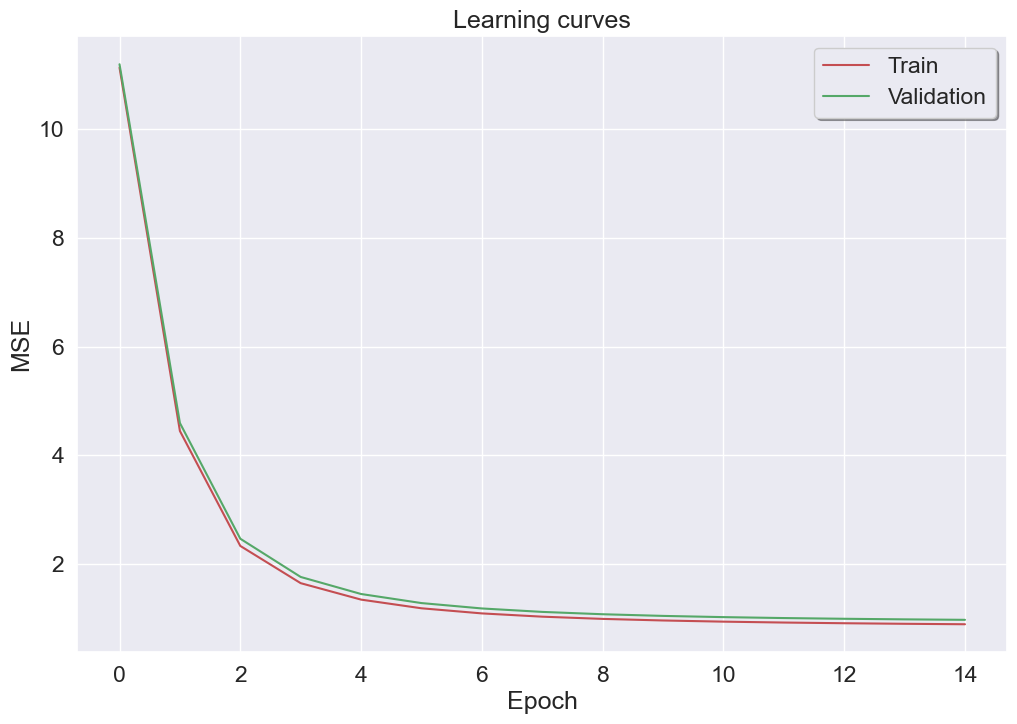

In [84]:
x = list(range(len(loss_train)))
k=0

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)

plt.plot(x[-k:], loss_train[-k:], 'r', label="Train")
plt.plot(x[-k:], loss_valid[-k:], 'g', label="Validation")
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
leg = plt.legend(loc='best', shadow=True, fancybox=True)

## Question 7
 
Hỏi nếu vòng lặp thực hiện nhiều lần thì sẽ gặp phải vấn đề gì?

In [85]:
# TODO 7.
"""
Nếu vòng lặp (epochs) thực hiện NHIỀU LẦN sẽ gặp vấn đề:

1. OVERFITTING (Quan trọng nhất):
   - Model học thuộc training data thay vì học pattern chung
   - Train loss giảm NHƯNG validation loss tăng lên
   - Kết quả: Model kém trên dữ liệu mới (test set, real users)

2. LÃNG PHÍ THỜI GIAN:
   - Training lâu mà không cải thiện gì thêm
   - Loss không giảm nữa nhưng vẫn chạy tiếp

3. NUMERICAL ISSUES:
   - Gradient có thể explode hoặc vanish
   - Giá trị P, Q trở nên bất ổn

MINH HỌA:
Epoch 10:  Train = 1.0,  Valid = 1.1  ✓ Good
Epoch 50:  Train = 0.5,  Valid = 0.6  ✓ Still good  
Epoch 100: Train = 0.3,  Valid = 0.8  ✗ OVERFITTING!
Epoch 150: Train = 0.2,  Valid = 1.0  ✗ Worse!

GIẢI PHÁP:
- Sử dụng early stopping (đã có trong code)
- Dừng khi validation loss không cải thiện thêm
"""

'\nNếu vòng lặp (epochs) thực hiện NHIỀU LẦN sẽ gặp vấn đề:\n\n1. OVERFITTING (Quan trọng nhất):\n   - Model học thuộc training data thay vì học pattern chung\n   - Train loss giảm NHƯNG validation loss tăng lên\n   - Kết quả: Model kém trên dữ liệu mới (test set, real users)\n\n2. LÃNG PHÍ THỜI GIAN:\n   - Training lâu mà không cải thiện gì thêm\n   - Loss không giảm nữa nhưng vẫn chạy tiếp\n\n3. NUMERICAL ISSUES:\n   - Gradient có thể explode hoặc vanish\n   - Giá trị P, Q trở nên bất ổn\n\nMINH HỌA:\nEpoch 10:  Train = 1.0,  Valid = 1.1  ✓ Good\nEpoch 50:  Train = 0.5,  Valid = 0.6  ✓ Still good  \nEpoch 100: Train = 0.3,  Valid = 0.8  ✗ OVERFITTING!\nEpoch 150: Train = 0.2,  Valid = 1.0  ✗ Worse!\n\nGIẢI PHÁP:\n- Sử dụng early stopping (đã có trong code)\n- Dừng khi validation loss không cải thiện thêm\n'

Bây giờ mô hình của chúng ta đã được đào tạo, hãy đánh giá hiệu suất cuối cùng của mô hình.

## Question 8
 
Hãy điền vào dòng code bên dưới để in ra giá trị lost.

In [86]:
# TODO 8.
loss(test, P, Q)

np.float64(1.0244666159146922)

## 2.4 Analysis

### 2.4.1 Exploring latent layers
 
Thanks to matrix factorization, it is possible to explore the various latent variables associated with users and items. By the nature of the matrices $\mathbf{P}$ and $\mathbf{Q}$, we can explore the <i>k</i> latent variables by looking at the columns of $\mathbf{P}$ and $\mathbf{Q}$.
 
For example, suppose that the first two latent variables in $\mathbf{Q}$ are the following, where each value in these arrays corresponds to an item:
 
$$
\begin{align}
q_1 &= [-1.0, \ -0.8, \ 0.0, \ 1.0, \ 0.5, \ ...]
\qquad \text {and} \qquad
q_2 = [-1.0, \ 0.8, \ 1.0, \ 0.5, \ -0.8, \ ...].
\end{align}
$$
 
Let's suppose that these underlying items correspond to the following movies:
 
1. The Room (2003),
2. Star Wars: Attack of the clones (2002),
3. Titanic (1997),
4. Citizen Kane (1954),
5. The Nigthmare before Christmas (1993).
 
By mapping these movies according to the associated values ​​of the first two latent variables, we obtain the following graph:
 
<img src = "https://user-images.githubusercontent.com/13997178/91663551-9486d300-eab7-11ea-8e9f-c58398eff9fe.png" width = "500">
 
When doing this, we might begin to see some patterns around what each latent variable might correspond to. In this case, we could imagine that the first latent variable here is associated with how well received the movie was, while the second variable may detect the presence of a superstar.
 
This might be an interesting hypothesis! Let's see if we see similar patterns when we look at the values associated with the matrix of users, $ \mathbf{P}$.
 
Suppose now that the first two latent variables of the $\mathbf{P}$ user matrix have the following values:
 
$$
\begin{align}
p_1 &= [1.0, \ 0.0, \ -0.5, \ 1.0, \ -1.0, \ ...]
\qquad \text{and} \qquad
p_2 = [1.0, \ 0.0, \ 0.5, \ -1.0, \ -0.8, \ ...]
\end{align}
$$
 
And that that each value in these two arrays correspond to the following users.
 
1. Serena,
2. Kali,
3. Neil,
4. Mary,
5. David.
 
We will now map the users according to the values associated with $ p_1 $ and $ p_2 $ vectors. Note, here we considered the same two latent factors, such that we can investigate how they compare to the characterization of the axes that we obtained before:
 
<img src = "https://user-images.githubusercontent.com/13997178/91663557-9e103b00-eab7-11ea-9ee1-0de6a5ac3760.png" width = "500">
 
 
 
This approach could allow us to suggest new movies that have never been evaluated by users simply based on certain characteristics. For example, there is a good chance that Serena loves the upcoming Scorsese <i> The Irish man </i> movie and that Neil looks forward to the new <i> Cat </i>.
We will now propose a function that will facilitate the exploration of latent variables.


In [87]:
def explore(movie_titles, latent_matrix, frequency_mask, factor_idx, k):
    """
    Args:
       movie_titles: Pandas Series containing movie titles
        latent_matrix: matrix containing the model parameters for movies
        frequency_mask: boolean array masking non-frequent movies
        factor_idx: index of the latent variable
        k: number of movies to show

    Returns:
        names: movie titles
        scores: associated predicted ratings of movies
    """

    # slice the column to obtain latent variable, then apply mask
    latent_variable = latent_matrix[:, factor] * frequency_mask

    # filter out infrequent movies
    nonzero_indices = np.nonzero(latent_variable)
    movies = np.array(movie_titles)[nonzero_indices][:k]
    latent_variable = latent_variable[nonzero_indices][:k]

    return movies, latent_variable

Let's now go ahead and use this function to visualize the results. 
We will do this while only considering movies that have been watched by
at least 10% of all users. To do this, let's use the movie_popularity list we created earlier.

In [88]:
# print(movie_popularity)
# print(movie_popularity.shape)

In [89]:
k = 5
factor = 0
threshold = 0.1
names, scores = explore(movies['Title'], Q, np.where(movie_popularity > threshold, 1, 0), factor, k)

df = pd.DataFrame(np.matrix((names, scores)).T, (np.arange(len(scores)) + 1).tolist())
df.columns = ['Title', 'Latent factor']
df

,Title,Latent factor
1,Toy Story (1995),0.880782
2,GoldenEye (1995),0.729944
3,Get Shorty (1995),0.795849
4,Twelve Monkeys (1995),0.867367
5,Babe (1995),0.970024


## Question 9

Hỏi các latent variables có thể diễn giải được không?

In [90]:
# TODO 9.
"""
CÂU TRẢ LỜI: Các latent variables CÓ THỂ diễn giải được NHƯNG KHÔNG HOÀN TOÀN RÕ RÀNG.

1. DIỄN GIẢI ĐƯỢC (Interpretable):
   
   a) Có thể phát hiện patterns:
   - Latent variable 1 có thể đại diện cho "quality/popularity" của phim
   - Latent variable 2 có thể capture "presence of superstar actors"
   - Latent variable 3 có thể liên quan đến "genre" (action, romance, etc.)
   
   b) Ví dụ từ tutorial:
   - Phim có latent value cao ở dimension 1 → được đánh giá tốt (Citizen Kane)
   - Phim có latent value thấp → chất lượng kém (The Room)
   - User có latent value cao → thích phim chất lượng cao

2. KHÔNG DIỄN GIẢI HOÀN TOÀN (Not Fully Interpretable):
   
   a) Lý do:
   - Latent variables được học TỰ ĐỘNG từ data
   - KHÔNG CÓ LABEL rõ ràng (unsupervised learning)
   - Mỗi dimension là COMBINATION của nhiều features
   - Ý nghĩa có thể THAY ĐỔI giữa các lần training
   
   b) Ví dụ:
   - Dimension 1 có thể vừa capture quality VÀ popularity VÀ release year
   - Không tách biệt rõ ràng như supervised features
   - Chỉ có thể GIẢ ĐỊNH ý nghĩa qua observation

3. PHƯƠNG PHÁP DIỄN GIẢI:
   
   a) Visualization:
   - Plot movies/users theo 2 latent dimensions
   - Tìm patterns và clusters
   - Nhận xét movies có latent values tương tự
   
   b) Analysis:
   - Xem movies nào có highest/lowest values
   - So sánh với known attributes (genre, year, rating)
   - Correlation analysis
   
   c) Example code:
   # Xem top 5 movies cho latent factor 0
   names, scores = explore(movies['Title'], Q, mask, factor=0, k=5)
   # Quan sát xem đây là phim gì → suy luận ý nghĩa

4. SO SÁNH VỚI EXPLICIT FEATURES:
   
   Explicit (Diễn giải rõ ràng):
   - Genre: Action, Comedy, Drama → biết chính xác
   - Year: 1990, 2000 → cụ thể
   - Director: Spielberg, Nolan → rõ ràng
   
   Latent (Không rõ ràng):
   - Dimension 1: [-0.5, 0.2, 1.3, ...] → nghĩa là gì?
   - Có thể là mix của nhiều thứ
   - Cần phân tích để đoán

5. ƯU ĐIỂM CỦA LATENT VARIABLES:
   
   - Capture được HIDDEN PATTERNS mà explicit features không thấy
   - Tự động học từ data → không cần manual labeling
   - Có thể discover NEW insights
   - Hiệu quả hơn trong prediction

6. NHƯỢC ĐIỂM:
   
   - Khó EXPLAIN cho stakeholders
   - Không biết chính xác model đang học gì
   - Black box nature
   - Khó debug khi có vấn đề

KẾT LUẬN:
Latent variables CÓ THỂ diễn giải được ở MỨC ĐỘ TƯƠNG ĐỐI thông qua visualization 
và analysis, NHƯNG KHÔNG BAO GIỜ rõ ràng như explicit features. Chúng ta chỉ có thể 
ĐƯA RA GIẢ THUYẾT về ý nghĩa dựa trên observation, không có ground truth.
"""

'\nCÂU TRẢ LỜI: Các latent variables CÓ THỂ diễn giải được NHƯNG KHÔNG HOÀN TOÀN RÕ RÀNG.\n\n1. DIỄN GIẢI ĐƯỢC (Interpretable):\n   \n   a) Có thể phát hiện patterns:\n   - Latent variable 1 có thể đại diện cho "quality/popularity" của phim\n   - Latent variable 2 có thể capture "presence of superstar actors"\n   - Latent variable 3 có thể liên quan đến "genre" (action, romance, etc.)\n   \n   b) Ví dụ từ tutorial:\n   - Phim có latent value cao ở dimension 1 → được đánh giá tốt (Citizen Kane)\n   - Phim có latent value thấp → chất lượng kém (The Room)\n   - User có latent value cao → thích phim chất lượng cao\n\n2. KHÔNG DIỄN GIẢI HOÀN TOÀN (Not Fully Interpretable):\n   \n   a) Lý do:\n   - Latent variables được học TỰ ĐỘNG từ data\n   - KHÔNG CÓ LABEL rõ ràng (unsupervised learning)\n   - Mỗi dimension là COMBINATION của nhiều features\n   - Ý nghĩa có thể THAY ĐỔI giữa các lần training\n   \n   b) Ví dụ:\n   - Dimension 1 có thể vừa capture quality VÀ popularity VÀ release year\n  

# 3. Applications
 
Congratulations on making it so far and on building your first recommender system! We can now put our model to use and generate personalized recommendations for users. In this section we will do just that.
 
We will choose a given user, and consider her preferences. Then we will generate recommendations for her using our trained matrix factorization model with the caveat in mind that we only want to recommend movies that she has not seen in the past.
 
Với một người dùng nhất định, hãy tạo 10 đề xuất phim phù hợp nhất dựa trên sở thích của người dùng. Chúng tôi đã xác định các bước cần thiết để bạn thực hiện việc này. Bạn cũng có thể thấy hữu ích khi sử dụng hàm `rank_top_k` mà chúng tôi đã cung cấp bên dưới.

In [91]:
def rank_top_k(names, ratings, k=10):
   """
   Example:
   a, b = np.array(['a', 'b', 'c']), np.array([6, 1, 3])
   a, b = rank_top_k(a, b, k=2)
   >>> a
   np.array('a', 'c')
   >>> b
   np.array([6, 3])
   """
   # rank indices in descending order
   ranked_ids = np.argsort(ratings)[::-1]
   return names[ranked_ids][:k], ratings[ranked_ids][:k]

In [92]:
user_id = 0
top_k = 10
# Step 1: Define the user's preferences using the training set.
user_train = np.array(train[0][user_id])
# Step 2: Define what movies the user has not seen yet.
# We will only generate recommendations for these movies, so make sure we store this in an awway equal to the number of all movies.
movies_not_seen = np.where(user_train == 0, 1, 0)
# Step 3: Predict the user's ratings across all movies.
estimates = np.dot(P[user_id, :], Q.T)
# Step 4: Consider the estimated ratings for movies that were not seen by the user.
unseen_movie_estimates = estimates * movies_not_seen
# Step 5: Retrieve the top k recommendations for that user.
recommendations, scores = rank_top_k(np.array(movies['Title']), unseen_movie_estimates, k=top_k)
# Step 6: Show the title and associated latent feature of the recommendations
df = pd.DataFrame(np.matrix((recommendations, scores)).T, (np.arange(10) + 1).tolist(), 
                  columns=['Title', 'Predicted rating'])
df

,Title,Predicted rating
1,"Close Shave, A (1995)",4.808837
2,"Wrong Trousers, The (1993)",4.765623
3,Schindler's List (1993),4.725408
4,"Usual Suspects, The (1995)",4.607114
5,Casablanca (1942),4.600347
6,Star Wars (1977),4.574316
7,"Shawshank Redemption, The (1994)",4.554362
8,"Third Man, The (1949)",4.549039
9,Wallace & Gromit: The Best of Aardman Animatio...,4.545403
10,Rear Window (1954),4.537851


It could also be interesting to recommend movies to a user considering not only her past movie ratings, but also her preference for various movie genres.
 
## Question 10
 
Hãy tưởng tượng người dùng của chúng ta đang duyệt qua một danh sách phim hoạt hình. Để cung cấp cho người dùng bộ phim phù hợp nhất, chúng ta có thể muốn giới hạn các đề xuất vào một thể loại cụ thể. Hãy hoàn chỉnh dòng code bên dưới:

In [93]:
def recommend(user_id, data, P, Q, list_of_genre_names, movies_genre, genre):
    """
    args:
       user_id: user_id
        data: user-item ratings
        P: user matrix
        Q: item matrix
        list_of_genre_names: list of genre names
        movies_genre: user's preference for genres
        new: Boolean, do we want to make new recommendations or not?

    Returns:
        the best suggestions based on the genre of movie selected
    """

    # # TODO 10.
    # ranked_ids = 
    # return np.array(predictions) * np.array(genre.T)[0]
    # Tính predicted ratings cho tất cả phim
    all_predictions = np.dot(P[user_id, :], Q.T)
    
    # Tìm index của genre trong list_of_genre_names
    genre_idx = list(list_of_genre_names).index(genre)
    
    # Tạo mask: chỉ lấy phim thuộc genre này (movies_genre[:, genre_idx] == 1)
    genre_mask = np.array(movies_genre[:, genre_idx]).flatten()
    
    # Áp dụng mask: phim không thuộc genre này sẽ có rating = 0
    filtered_predictions = all_predictions * genre_mask
    
    return filtered_predictions

In [94]:
print(movies_genre_name)
print(movies_genre.shape)

['unknown' 'Action' 'Adventure' 'Animation' "Children's" 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']
(1682, 19)


In [95]:
genre = "Animation"
user_id = 1
top_k = 5
 
# Estimate recommendations
estimates = recommend(user_id, train, P, Q, list_of_genre_names=movies_genre_name, movies_genre=movies_genre, genre=genre)
recommendations, scores = rank_top_k(np.array(movies['Title']), estimates, k=top_k)
 
# Presentation
df = pd.DataFrame(np.matrix((recommendations, scores)).T, (np.arange(top_k) + 1).tolist(), columns = ['Title', 'Predicted rating'])
df

,Title,Predicted rating
1,"Close Shave, A (1995)",4.810264
2,"Wrong Trousers, The (1993)",4.772905
3,Wallace & Gromit: The Best of Aardman Animatio...,4.548193
4,"Grand Day Out, A (1992)",4.266599
5,Ghost in the Shell (Kokaku kidotai) (1995),4.08024


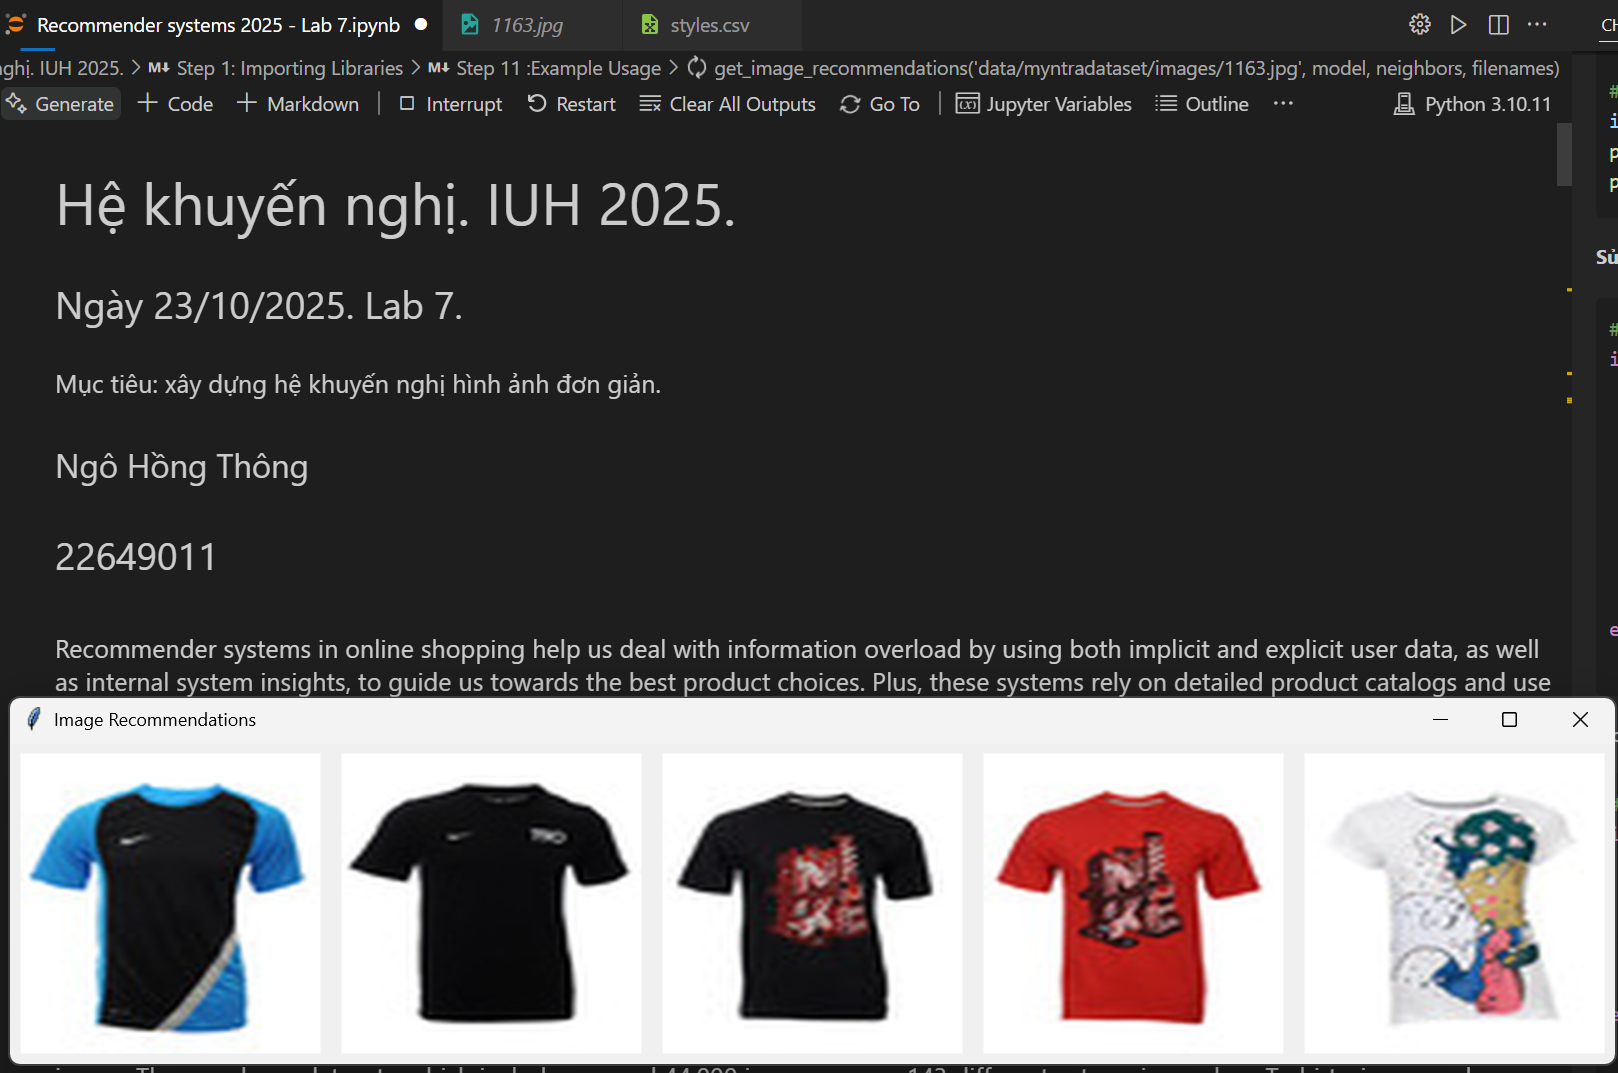